# Setup


**Imports**


In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Utility functions**


In [2]:
phi = (1 + 5**0.5) / 2  # golden ratio ≈ 1.618


def fig_ax(figsize=(phi * 4, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis="x", tight=True)
    return fig, ax

## Question 3


Calculated Parameters:
phi_1 = 0.9524
phi_2 = -0.9070


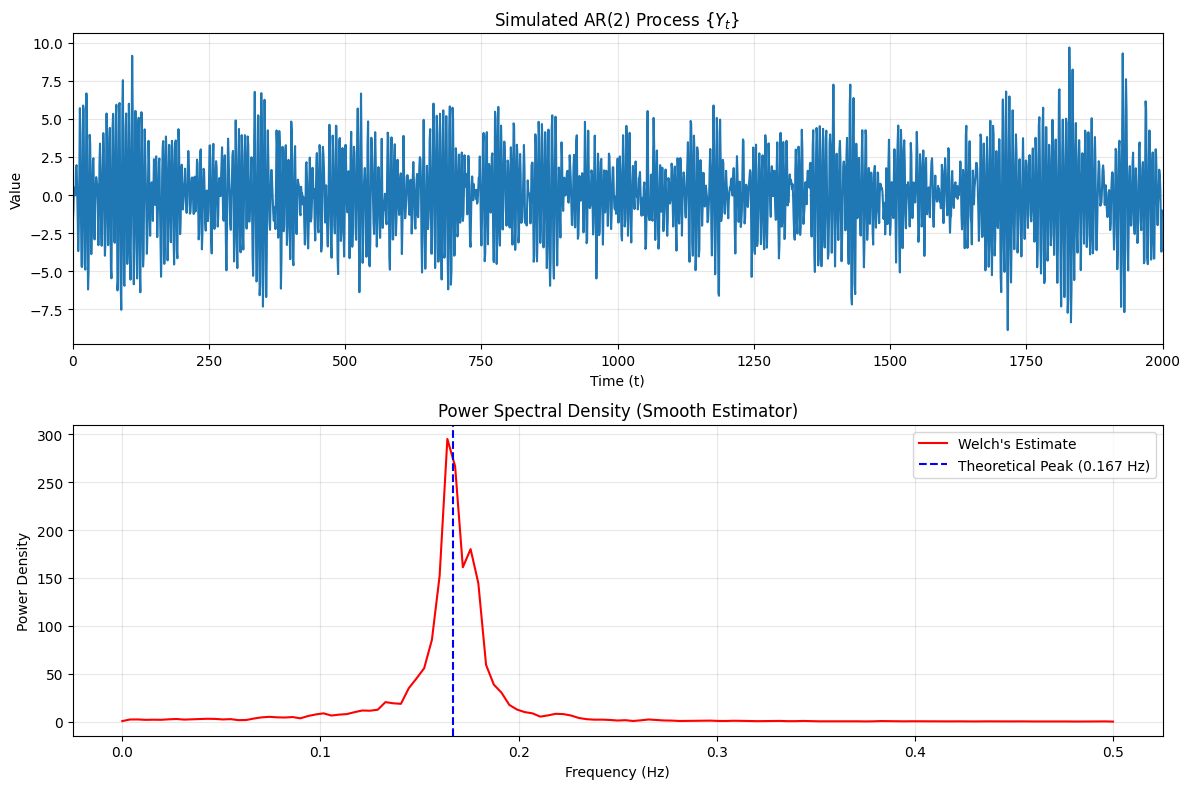

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# --- 1. Define Parameters ---
n_samples = 2000
r = 1.05
theta = 2 * np.pi / 6  # 2pi/6 = pi/3

# --- 2. Calculate AR Coefficients ---
# Based on the derivation:
# phi_1 = 1/r1 + 1/r2 = 2*cos(theta)/r
# phi_2 = -1/(r1*r2) = -1/r^2
phi_1 = (2 * np.cos(theta)) / r
phi_2 = -1 / (r**2)

print(f"Calculated Parameters:")
print(f"phi_1 = {phi_1:.4f}")
print(f"phi_2 = {phi_2:.4f}")

# --- 3. Simulate the Process ---
# We generate a bit more than n_samples to discard the transient "burn-in" phase
burn_in = 100
total_n = n_samples + burn_in

np.random.seed(42)  # Set seed for reproducibility
epsilon = np.random.normal(0, 1, total_n)  # White noise (variance 1)
Y = np.zeros(total_n)

# AR(2) Recursion: Y_t = phi_1*Y_{t-1} + phi_2*Y_{t-2} + epsilon_t
for t in range(2, total_n):
    Y[t] = phi_1 * Y[t-1] + phi_2 * Y[t-2] + epsilon[t]

# Discard burn-in samples
Y = Y[burn_in:]

# --- 4. Compute Power Spectrum (Smooth Estimator) ---
# We use Welch's method for a smooth estimate of the PSD
# fs=1 corresponds to the 1 Hz assumption
frequencies, power_spectrum = welch(Y, fs=1.0, nperseg=256)

# Theoretical Peak Location (for comparison)
theoretical_peak = theta / (2 * np.pi)

# --- 5. Plotting (Figure 2) ---
plt.figure(figsize=(12, 8))

# Subplot 1: Time Series Signal
plt.subplot(2, 1, 1)
plt.plot(Y)
plt.title(r'Simulated AR(2) Process $\{Y_t\}$')
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.xlim(0, n_samples)
plt.grid(True, alpha=0.3)

# Subplot 2: Periodogram (Smooth Estimator)
plt.subplot(2, 1, 2)
plt.plot(frequencies, power_spectrum, color='red', label="Welch's Estimate")
plt.axvline(x=theoretical_peak, color='blue', linestyle='--', label=f'Theoretical Peak ({theoretical_peak:.3f} Hz)')
plt.title(f'Power Spectral Density (Smooth Estimator)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Question 4


In [3]:
# np.save('data/signal_question_4.npy', signal_question_4)
signal_question_4 = np.load("data/signal_question_4.npy")

In [4]:
print(len(signal_question_4))

2048


[]

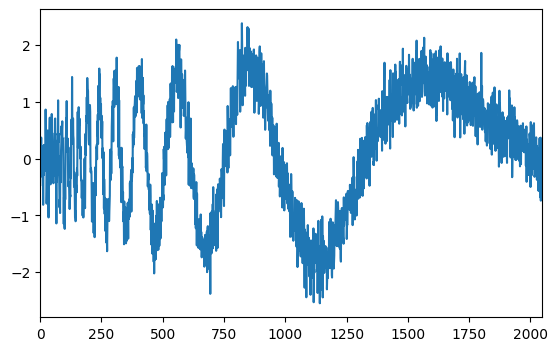

In [5]:
fig, ax = fig_ax()
ax.plot(signal_question_4)
plt.plot()

In [6]:
L_list = [32, 64, 128, 256, 512, 1024]

In [7]:
def mdct_atoms(L):

    # create time index u = 0,...,2L-1
    u = np.arange(2 * L)

    # compute window w_L[u]
    w = np.sin(np.pi / (2 * L) * (u + 1 / 2))

    # scale factor
    norm_factor = np.sqrt(2 / L)

    atoms = []
    for k in range(L):
        # cosine modulation
        cos_phase = (np.pi / L) * (u + (L + 1) / 2) * (k + 1 / 2)
        cos_part = np.cos(cos_phase)

        # construct atom
        phi = w * norm_factor * cos_part

        # normalize for stability
        phi /= np.linalg.norm(phi)

        atoms.append(phi)

    return np.array(atoms)

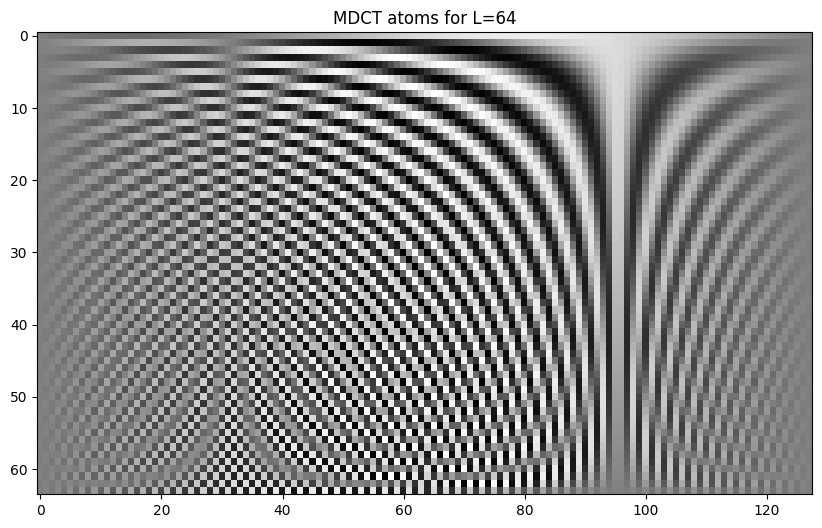

In [8]:
# visualization of MDCT atoms
L_vis = 64
atoms_vis = mdct_atoms(L_vis)
fig, ax = fig_ax(figsize=(10, 6))
ax.imshow(atoms_vis, aspect="auto", cmap="gray_r")
ax.set_title(f"MDCT atoms for L={L_vis}")
plt.show()

In [9]:
def omp_mdct(x, scales, mdct_atoms, n_atoms=10):
    """
    orthogonal matching pursuit using mdct atoms
    args:
        x : input signal (1d numpy array)
        scales : list of L values, e.g. [32,64,128,...]
        mdct_atoms : function L -> list of 1d atoms φ_{L,k}[u] of length 2L
        n_atoms : number of atoms to select
    returns:
        x_hat : reconstructed signal
        coeffs : coefficients of selected atoms
        active_atoms : list of selected atoms (full-length signals)
        residual_norms : list of residual norms at each iteration
    """
    N = len(x)
    residual = x.copy()
    # list of selected atoms (full-length signals)
    active_atoms = []
    # matrix whose columns are selected atoms
    active_matrix = None

    coeffs = None
    residual_norms = [np.linalg.norm(residual)]

    for _ in range(n_atoms):

        best_corr = 0.0
        best_atom = None

        # loop on scales
        for L in scales:
            atoms_L = mdct_atoms(L)  # returns list of φ_{L,k}
            window_len = 2 * L

            # loop on frequencies
            for phi in atoms_L:
                # convolution gives correlations over all valid shifts
                corr = np.convolve(residual, phi[::-1], mode="valid")

                # find best shift for this atom
                idx = np.argmax(np.abs(corr))
                if abs(corr[idx]) > best_corr:
                    best_corr = abs(corr[idx])
                    tau = idx

                    # create full-length embedded atom
                    full = np.zeros(N)
                    full[tau : tau + window_len] = phi
                    best_atom = full

        # append selected atom
        active_atoms.append(best_atom)

        # build active dictionary matrix
        A = np.column_stack(active_atoms)

        # orthogonal projection via least squares
        coeffs, _, _, _ = np.linalg.lstsq(A, x, rcond=None)

        # update residual
        residual = x - A @ coeffs
        residual_norms.append(np.linalg.norm(residual))

    # final reconstruction
    x_hat = A @ coeffs

    return x_hat, coeffs, active_atoms, np.array(residual_norms)

In [10]:
# run
n_atoms = 10
x_hat, coeffs, atoms, res_norms = omp_mdct(
    signal_question_4, L_list, mdct_atoms, n_atoms=n_atoms
)

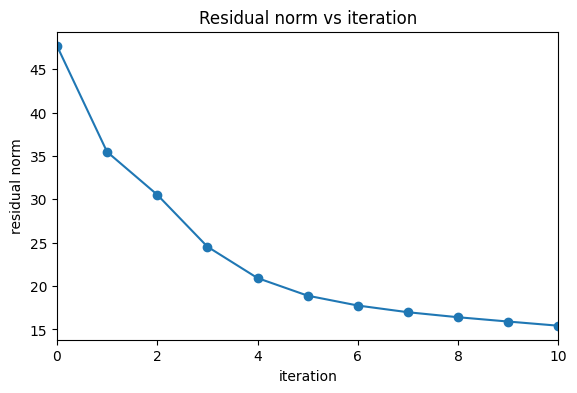

In [11]:
# plots residual norms
import matplotlib.pyplot as plt

fig, ax = fig_ax()
ax.plot(res_norms, marker="o")
ax.set_xlabel("iteration")
ax.set_ylabel("residual norm")
ax.set_title("Residual norm vs iteration")
plt.show()

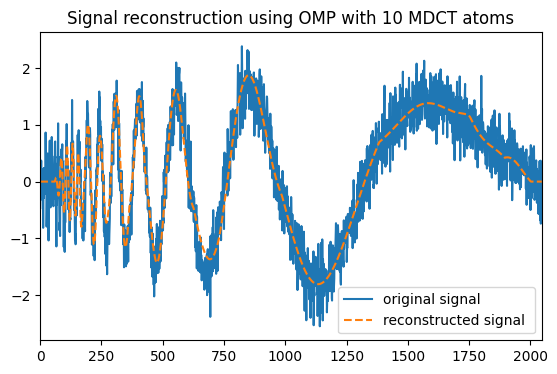

In [12]:
# plot reconstruction
fig, ax = fig_ax()
ax.plot(signal_question_4, label="original signal")
ax.plot(x_hat, label=f"reconstructed signal ", linestyle="--")
ax.legend()
ax.set_title(f"Signal reconstruction using OMP with {n_atoms} MDCT atoms")
plt.show()

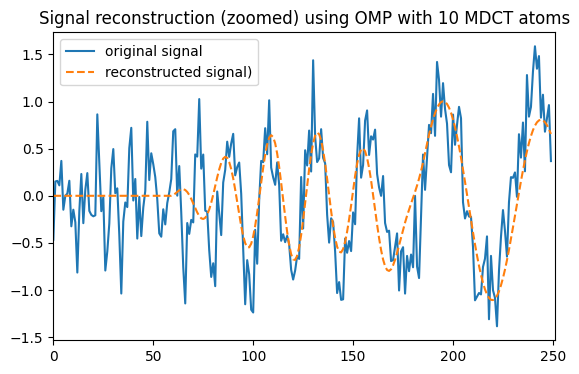

In [13]:
# plot reconstruction zoomed on beginning
end_idx = 250
fig, ax = fig_ax()
ax.plot(signal_question_4[:end_idx], label="original signal")
ax.plot(x_hat[:end_idx], label=f"reconstructed signal)", linestyle="--")
ax.set_xlim(0, end_idx + 1)
ax.legend()
ax.set_title(f"Signal reconstruction (zoomed) using OMP with {n_atoms} MDCT atoms")
plt.show()